#PRETRAINING TASK

In [42]:
#Importing Library
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import random
import os
import matplotlib.pyplot as plt




In [35]:
# Downloading CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='cifar_data/', download=True, train=True)

Files already downloaded and verified


Creating Jigsaws

In [36]:
def create_jigsaw(cifar_dataset, output_dir, num_puzzles):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(num_puzzles):
        random_index = random.randint(0, len(cifar_dataset) - 1)
        original_image, _ = cifar_dataset[random_index]

        width, height = original_image.size

       #Dimensions of each jigsaw piece
        piece_width = width // 2
        piece_height = height // 2

        jigsaw_pieces = []

        # Looping through the rows and columns to create the pieces
        for y in range(2):
            for x in range(2):
                left = x * piece_width
                upper = y * piece_height
                right = left + piece_width
                lower = upper + piece_height
                piece = original_image.crop((left, upper, right, lower))
                jigsaw_pieces.append(piece)

        # Shuffle the jigsaw pieces
        random.shuffle(jigsaw_pieces)

        # Create a blank canvas for the jigsaw puzzle
        jigsaw_puzzle = Image.new('RGB', (width, height))

        # Paste the shuffled pieces onto the canvas
        for y in range(2):
            for x in range(2):
                jigsaw_puzzle.paste(jigsaw_pieces.pop(0), (x * piece_width, y * piece_height))

        # Save the jigsaw image & original image
        jigsaw_puzzle.save(os.path.join(output_dir, f'jigsaw_puzzle_{i}.png'))
        original_image.save(os.path.join(output_dir, f'original_image_{i}.png'))


create_jigsaw(cifar_dataset, 'jigsaw_dataset/', num_puzzles=10000)


Creating custom Dataset

In [37]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class JigsawDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.startswith('jigsaw_puzzle')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        jigsaw_path = os.path.join(self.root_dir, f'jigsaw_puzzle_{idx}.png')
        original_path = os.path.join(self.root_dir, f'original_image_{idx}.png')

        jigsaw_image = Image.open(jigsaw_path)
        original_image = Image.open(original_path)

        if self.transform:
            jigsaw_image = self.transform(jigsaw_image)
            original_image = self.transform(original_image)

        return jigsaw_image, original_image


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


jigsaw_dataset = JigsawDataset(root_dir='jigsaw_dataset/', transform=transform)
data_loader = DataLoader(jigsaw_dataset, batch_size=64, shuffle=True, num_workers=4)


MODEL

In [38]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model()
model.to(device)

Model(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    for batch in data_loader:
        jigsaw_images, original_images = batch
        jigsaw_images = jigsaw_images.to(device)
        original_images = original_images.to(device)

        outputs = model(jigsaw_images)

        loss = criterion(outputs, original_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'jigsaw_reconstruction_model.pth')


Epoch [1/10], Loss: 0.0464
Epoch [2/10], Loss: 0.0443
Epoch [3/10], Loss: 0.0701
Epoch [4/10], Loss: 0.0423
Epoch [5/10], Loss: 0.0444
Epoch [6/10], Loss: 0.0489
Epoch [7/10], Loss: 0.0451
Epoch [8/10], Loss: 0.0437
Epoch [9/10], Loss: 0.0393
Epoch [10/10], Loss: 0.0410


(-0.5, 127.5, 127.5, -0.5)

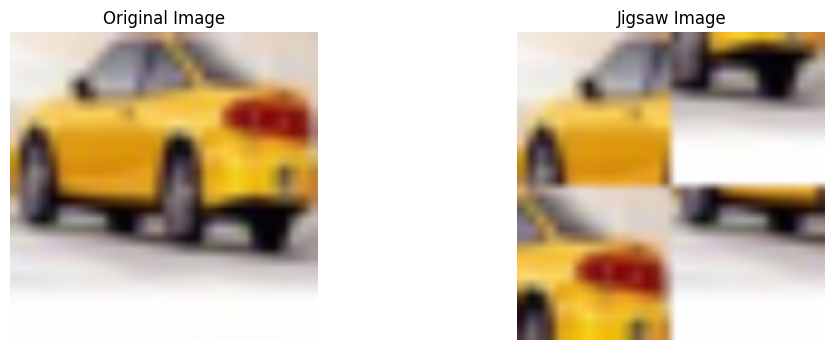

In [65]:
idx = 190
jigsaw_image, original_image = jigsaw_dataset[idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(original_image.permute(1,2,0))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(jigsaw_image.permute(1,2,0))
axes[1].set_title('Jigsaw Image')
axes[1].axis('off')


Visual Analysis

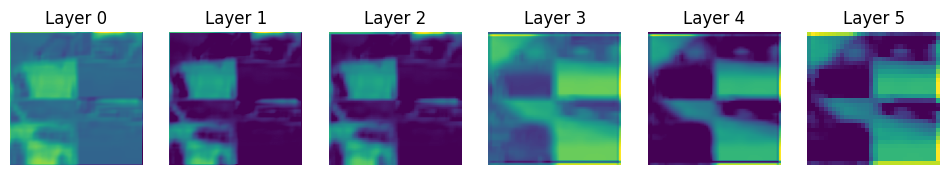

In [66]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


model = Model()
model.load_state_dict(torch.load('/content/jigsaw_reconstruction_model.pth'))
model.eval()


encoder = model.encoder


input_image, _ = jigsaw_dataset[idx]

activation_maps = []

with torch.no_grad():
    x = input_image.unsqueeze(0)
    for layer in encoder:
        x = layer(x)
        activation_maps.append(x)

# Visualize the activation maps from the encoder
fig, axes = plt.subplots(1, len(activation_maps), figsize=(12, 4))
for i, activation_map in enumerate(activation_maps):
    axes[i].imshow(activation_map[0, 0].cpu().numpy(), cmap='viridis')
    axes[i].set_title(f'Layer {i}')
    axes[i].axis('off')

plt.show()



###DOWNSTREAM TASK

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining a custom classification head
class ClassificationHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.fc(x)


pretrained_model = Model()
pretrained_model.load_state_dict(torch.load('jigsaw_reconstruction_model.pth'))
pretrained_model.eval()


pretrained_model.to(device)


num_classes = 10
classification_model = nn.Sequential(
    pretrained_model.encoder,
    nn.Flatten(),
    ClassificationHead(8192, num_classes)
)


classification_model.to(device)


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)


num_epochs = 20
for epoch in range(num_epochs):
    classification_model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = classification_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}')

print('Training finished')


Files already downloaded and verified
Epoch 1, Loss: 1.2872761339330308
Epoch 2, Loss: 0.9324986968961213
Epoch 3, Loss: 0.7907102318371043
Epoch 4, Loss: 0.6940730717176061
Epoch 5, Loss: 0.6168012159978947
Epoch 6, Loss: 0.5489644094386978
Epoch 7, Loss: 0.49028862050503413
Epoch 8, Loss: 0.4345344191278948
Epoch 9, Loss: 0.3856060537211883
Epoch 10, Loss: 0.3453061167922471
Epoch 11, Loss: 0.3018939199826449
Epoch 12, Loss: 0.2708475779541923
Epoch 13, Loss: 0.2440105733816581
Epoch 14, Loss: 0.21343271323310598
Epoch 15, Loss: 0.19041228790283965
Epoch 16, Loss: 0.16954425131649617
Epoch 17, Loss: 0.15318278459560536
Epoch 18, Loss: 0.13751895973206404
Epoch 19, Loss: 0.12631209258733275
Epoch 20, Loss: 0.11257554558784608
Training finished


In [74]:

test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


classification_model.eval()


correct = 0
total = 0


with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classification_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Files already downloaded and verified
Test Accuracy: 70.82%
